In [8]:
import sys
from pathlib import Path
import os
import pickle
import random
import shutil

import glob2 as glob
import tensorflow as tf
from azureml.core import Experiment, Workspace
from azureml.core.run import Run
from tensorflow.keras import callbacks

sys.path.append(str(Path(os.getcwd()) / 'src'))

from config import CONFIG
from constants import REPO_DIR
from model import create_cnn

sys.path.append(str(REPO_DIR / 'src/common'))

from model_utils.preprocessing import preprocess_depthmap, preprocess_targets
from model_utils.lr_finder import LRFinder

In [38]:
# Make experiment reproducible
tf.random.set_seed(CONFIG.SPLIT_SEED)
random.seed(CONFIG.SPLIT_SEED)

# Get the current run.
run = Run.get_context()

# Offline run. Download the sample dataset and run locally. Still push results to Azure.
if(run.id.startswith("OfflineRun")):
    print("Running in offline mode...")

    # Access workspace.
    print("Accessing workspace...")
    workspace = Workspace.from_config()
    experiment = Experiment(workspace, "training-junkyard")
    run = experiment.start_logging(outputs=None, snapshot_directory=None)

    # Get dataset.
    print("Accessing dataset...")
    dataset_name = CONFIG.DATASET_NAME  # DATASET_NAME_LOCAL
    dataset_path = str(REPO_DIR / "data" / dataset_name)
    if not os.path.exists(dataset_path):
        dataset = workspace.datasets[dataset_name]
        dataset.download(target_path=dataset_path, overwrite=False)

# Online run. Use dataset provided by training notebook.
else:
    print("Running in online mode...")
    experiment = run.experiment
    workspace = experiment.workspace
    dataset_path = run.input_datasets["dataset"]
    
dataset_path = os.path.join(dataset_path, "qrcode")

Running in offline mode...
Accessing workspace...
Accessing dataset...


In [39]:
# Get the QR-code paths.

print("Dataset path:", dataset_path)
#print(glob.glob(os.path.join(dataset_path, "*"))) # Debug
print("Getting QR-code paths...")
qrcode_paths = glob.glob(os.path.join(dataset_path, "*"))
print("qrcode_paths: ", len(qrcode_paths))
assert len(qrcode_paths) != 0

Dataset path: /Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode
Getting QR-code paths...
qrcode_paths:  20


In [40]:
dataset_path

'/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode'

In [41]:


# Shuffle and split into train and validate.
random.shuffle(qrcode_paths)
split_index = int(len(qrcode_paths) * 0.8)
qrcode_paths_training = qrcode_paths[:split_index]

del qrcode_paths

# Show split.
print("Paths for training:")
print("\t" + "\n\t".join(qrcode_paths_training))
print(len(qrcode_paths_training))

assert len(qrcode_paths_training) > 0


def get_depthmap_files(paths):
    pickle_paths = []
    for path in paths:
        pickle_paths.extend(glob.glob(os.path.join(path, "**", "*.p")))
    return pickle_paths


# Get the pointclouds.
print("Getting depthmap paths...")
paths_training = get_depthmap_files(qrcode_paths_training)

del qrcode_paths_training

print("Using {} files for training.".format(len(paths_training)))

# Function for loading and processing depthmaps.
def tf_load_pickle(path, max_value):
    def py_load_pickle(path, max_value):
        rgbd, targets = pickle.load(open(path.numpy(), "rb"))
        rgb = rgbd[0]  # shape: (240, 180, 3)
        depthmap = rgbd[1]  # shape: (240, 180)

        rgb = preprocess_depthmap(rgb)
        rgb = rgb / 255.

        depthmap = preprocess_depthmap(depthmap)
        depthmap = depthmap / max_value
        depthmap = tf.expand_dims(depthmap, -1)    # shape: (240, 180, 1)

        rgbd = tf.concat([rgb, depthmap], axis=2)
        rgbd = tf.image.resize(rgbd, (CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH))
        targets = preprocess_targets(targets, CONFIG.TARGET_INDEXES)
        return rgbd, targets

    rgbd, targets = tf.py_function(py_load_pickle, [path, max_value], [tf.float32, tf.float32])
    rgbd.set_shape((CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH, 4))
    targets.set_shape((len(CONFIG.TARGET_INDEXES,)))
    return rgbd, targets

Paths for training:
	/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode/1614660905-03xm1qik7d
	/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode/1614660905-051i3zee74
	/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode/1614660905-04revvtw2h
	/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode/1614660905-02bnl1pu9y
	/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode/1614660905-03bjhiqu4f
	/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode/1614660905-09crmikqiv
	/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode/1614660905-0795lwc3dp
	/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode/1614660905-06xqb10fgz
	/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode/1614660905-00stuh94p5
	/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans-mini/qrcode/1614660905-00gy12lz6g
	/Users/markus/Development/cgm

In [42]:
# def py_load_pickle(path, max_value):
#     rgbd, targets = pickle.load(open(path.numpy(), "rb"))
#     rgb = rgbd[0]  # shape: (240, 180, 3)
#     depthmap = rgbd[1]  # shape: (240, 180)

#     rgb = preprocess_depthmap(rgb)
#     rgb = rgb / 255.

#     depthmap = preprocess_depthmap(depthmap)
#     depthmap = depthmap / max_value
#     depthmap = tf.expand_dims(depthmap, -1)    # shape: (240, 180, 1)

#     rgbd = tf.concat([rgb, depthmap], axis=2)
#     rgbd = tf.image.resize(rgbd, (CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH))
#     targets = preprocess_targets(targets, CONFIG.TARGET_INDEXES)
#     return rgbd, targets

In [43]:
# aaa = '/Users/markus/Development/cgm/cgm-ml/data/anon-rgbd-5kscans/qrcode/1614660905-0b8q60a51i/102/1614660905-0b8q60a51i_1614798079500_102_1074.p'
# bbb = py_load_pickle(tf.constant(aaa), CONFIG.NORMALIZATION_VALUE)

In [44]:
# bbb[0].shape

In [57]:
# Create dataset for training.
paths = paths_training
dataset = tf.data.Dataset.from_tensor_slices(paths)
dataset_norm = dataset.map(lambda path: tf_load_pickle(path, CONFIG.NORMALIZATION_VALUE))
dataset_norm = dataset_norm.cache()
dataset_norm = dataset_norm.prefetch(tf.data.experimental.AUTOTUNE)
dataset_norm = dataset_norm.shuffle(CONFIG.SHUFFLE_BUFFER_SIZE)
dataset_training = dataset_norm
del dataset_norm

# Create dataset for validation.
# Note: No shuffle necessary.
# paths = paths_validate
# dataset = tf.data.Dataset.from_tensor_slices(paths)
# dataset_norm = dataset.map(lambda path: tf_load_pickle(path, CONFIG.NORMALIZATION_VALUE))
# dataset_norm = dataset_norm.cache()
# dataset_norm = dataset_norm.prefetch(tf.data.experimental.AUTOTUNE)
# dataset_validation = dataset_norm
# del dataset_norm

# Create dataset for activation
# paths = paths_activate
# dataset = tf.data.Dataset.from_tensor_slices(paths)
# dataset_norm = dataset.map(lambda path: tf_load_pickle(path, CONFIG.NORMALIZATION_VALUE))
# dataset_norm = dataset_norm.cache()
# dataset_norm = dataset_norm.prefetch(tf.data.experimental.AUTOTUNE)
# dataset_activation = dataset_norm
# del dataset_norm

# Note: Now the datasets are prepared.

# Create the model.
input_shape = (CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH, 4)
model = create_cnn(input_shape, dropout=False)

In [58]:
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

# LR Find

Epoch 1/5
46/46 - 66s - loss: 6888.2812 - mae: 82.0417
Epoch 2/5
46/46 - 65s - loss: 4495.5947 - mae: 61.3255
Epoch 3/5
46/46 - 67s - loss: 18564585472.0000 - mae: 22788.2598


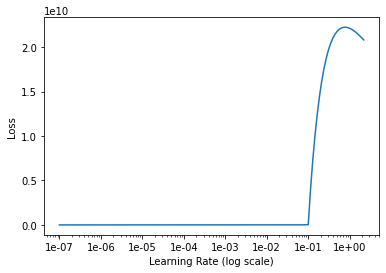

In [59]:
lr_finder = LRFinder(end_lr=0.02290) # otherwise plot looks unusable 
_ = model.fit(dataset_training.batch(CONFIG.BATCH_SIZE), epochs=5, callbacks=[lr_finder], verbose=2)
lr_finder.plot()

In [62]:
# LRFinder??

In [53]:
import matplotlib.pyplot as plt

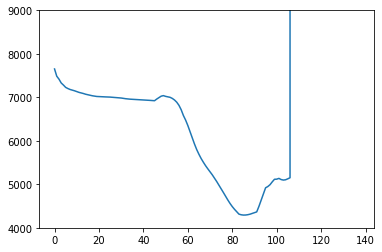

In [74]:
plt.plot(lr_finder.losses)
axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([4000,9000])
plt.show()

In [76]:
lr_finder.lrs[63]

0.00023806544027216172

In [60]:
list(zip(lr_finder.lrs, lr_finder.losses))

[(1e-07, 7652.171875),
 (1.1313535783640731e-07, 7485.214638157895),
 (1.2799609192771928e-07, 7418.1771217712185),
 (1.448088366190421e-07, 7330.06915618639),
 (1.638299954876917e-07, 7282.348892006605),
 (1.8534965163837e-07, 7229.075983944257),
 (2.0969599162960424e-07, 7202.242986095384),
 (2.3724031049875554e-07, 7180.332668495122),
 (2.6840267421497083e-07, 7166.095573341915),
 (3.036583259155938e-07, 7150.634540222209),
 (3.435449336246511e-07, 7132.5063358434845),
 (3.88670789985097e-07, 7114.06792614524),
 (4.3972408905523066e-07, 7101.07913791293),
 (4.974834216455176e-07, 7087.6624037368065),
 (5.628296492554594e-07, 7071.3026371969245),
 (6.367593376945601e-07, 7059.232836530593),
 (7.203999552574779e-07, 7047.4749359678735),
 (8.15027067233866e-07, 7036.211982271838),
 (9.2208378897861e-07, 7028.1341039481595),
 (1.0432027942124536e-06, 7019.95479632005),
 (1.1802312141916593e-06, 7016.96241042662),
 (1.3352588074727082e-06, 7012.854668488665),
 (1.5106498298763937e-06, 70

In [ ]:
len(dataset_training)

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 240, 180, 32)      1184      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 240, 180, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 120, 90, 32)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 120, 90, 32)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 120, 90, 64)       18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 120, 90, 64)       36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 45, 64)       